In [1]:
import json

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import StratifiedKFold

In [2]:
DATA_DIR = "/opt/ml/detection/dataset"

# Make Dataframe format (csv format)

In [16]:
with open(f'{DATA_DIR}/train.json', 'r') as f:
    train_json = json.load(f)

In [17]:
annotations_df = pd.DataFrame(train_json['annotations'])

In [18]:
# bbox (xmin, ymin, w, h)
annotations_df

,image_id,category_id,area,bbox,iscrowd,id
0,0,0,257301.66,"[197.6, 193.7, 547.8, 469.7]",0,0
1,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1
2,1,7,26259.36,"[0.0, 455.6, 144.6, 181.6]",0,2
3,1,4,69096.17,"[722.3, 313.4, 274.3, 251.9]",0,3
4,1,5,24164.58,"[353.2, 671.0, 233.7, 103.4]",0,4
...,...,...,...,...,...,...
23139,4882,5,768591.81,"[0.0, 116.2, 944.1, 814.1]",0,23139
23140,4882,7,57309.72,"[302.1, 439.3, 265.2, 216.1]",0,23140
23141,4882,0,1772.74,"[511.3, 451.1, 58.7, 30.2]",0,23141
23142,4882,1,53008.67,"[255.0, 421.4, 271.7, 195.1]",0,23142


In [19]:
bbox_array = np.array(annotations_df['bbox'].to_list())
bbox_array.shape

(23144, 4)

In [20]:
# x
annotations_df['x_min'] = bbox_array[:, 0]
annotations_df['x_center'] = bbox_array[:, 0] + bbox_array[:, 2]/2
annotations_df['x_max'] = bbox_array[:, 0] + bbox_array[:, 2]
# y
annotations_df['y_min'] = bbox_array[:, 1]
annotations_df['y_center'] = bbox_array[:, 1] + bbox_array[:, 3]/2
annotations_df['y_max'] = bbox_array[:, 1] + bbox_array[:, 3]
annotations_df['y_min'] = bbox_array[:, 1]
# w
annotations_df['w'] = bbox_array[:, 2]
# h
annotations_df['h'] = bbox_array[:, 3]

In [21]:
annotations_df

,image_id,category_id,area,bbox,iscrowd,id,x_min,x_center,x_max,y_min,y_center,y_max,w,h
0,0,0,257301.66,"[197.6, 193.7, 547.8, 469.7]",0,0,197.6,471.50,745.4,193.7,428.55,663.4,547.8,469.7
1,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1,0.0,28.80,57.6,407.4,497.70,588.0,57.6,180.6
2,1,7,26259.36,"[0.0, 455.6, 144.6, 181.6]",0,2,0.0,72.30,144.6,455.6,546.40,637.2,144.6,181.6
3,1,4,69096.17,"[722.3, 313.4, 274.3, 251.9]",0,3,722.3,859.45,996.6,313.4,439.35,565.3,274.3,251.9
4,1,5,24164.58,"[353.2, 671.0, 233.7, 103.4]",0,4,353.2,470.05,586.9,671.0,722.70,774.4,233.7,103.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23139,4882,5,768591.81,"[0.0, 116.2, 944.1, 814.1]",0,23139,0.0,472.05,944.1,116.2,523.25,930.3,944.1,814.1
23140,4882,7,57309.72,"[302.1, 439.3, 265.2, 216.1]",0,23140,302.1,434.70,567.3,439.3,547.35,655.4,265.2,216.1
23141,4882,0,1772.74,"[511.3, 451.1, 58.7, 30.2]",0,23141,511.3,540.65,570.0,451.1,466.20,481.3,58.7,30.2
23142,4882,1,53008.67,"[255.0, 421.4, 271.7, 195.1]",0,23142,255.0,390.85,526.7,421.4,518.95,616.5,271.7,195.1


# Split data

- reference
https://www.kaggle.com/backtracking/smart-data-split-train-eval-for-object-detection/notebook

In [112]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2013)
df_folds = annotations_df[['image_id']].copy()

In [113]:
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'object_count'] = annotations_df.groupby('image_id')['category_id'].nunique()
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['object_count'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 10}').values.astype(str)
)

In [114]:
df_folds

,bbox_count,object_count,stratify_group
image_id,,,
0,1,1,1_0
1,8,5,5_0
2,1,1,1_0
3,2,2,2_0
4,6,2,2_0
...,...,...,...
4878,1,1,1_0
4879,4,3,3_0
4880,1,1,1_0


In [115]:
df_folds.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/opt/conda/envs/py39_venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [116]:
df = annotations_df.copy()
df_folds

,bbox_count,object_count,stratify_group,fold
image_id,,,,
0,1,1,1_0,2
1,8,5,5_0,2
2,1,1,1_0,1
3,2,2,2_0,4
4,6,2,2_0,1
...,...,...,...,...
4878,1,1,1_0,4
4879,4,3,3_0,0
4880,1,1,1_0,3


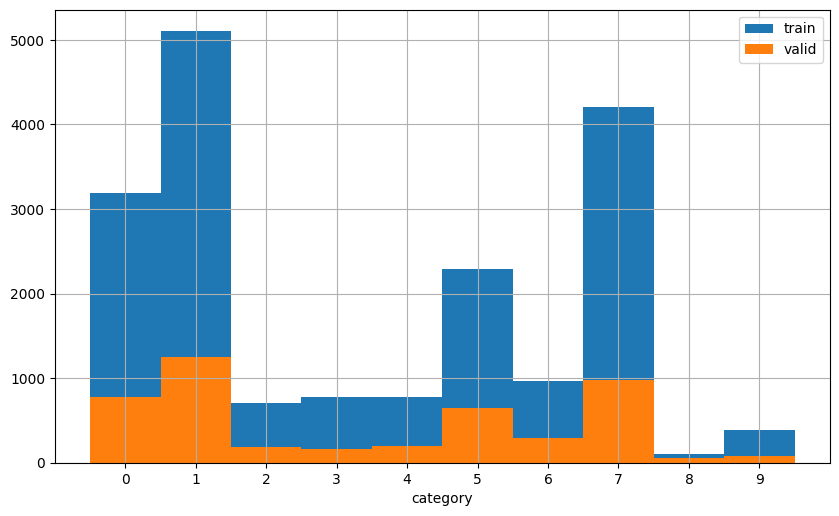

In [120]:
df_folds.reset_index(inplace=True)

df_valid = pd.merge(df, df_folds[df_folds['fold'] == 0], on='image_id')
df_train = pd.merge(df, df_folds[df_folds['fold'] != 0], on='image_id')

fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=100)
df_train['category_id'].hist(ax=ax, bins=np.arange(-1, 10)+0.5, label='train')
df_valid['category_id'].hist(ax=ax, bins=np.arange(-1, 10)+0.5, label='valid')
ax.set_xticks([_ for _ in range(10)])
ax.set_xlabel('category')
ax.legend()

In [159]:
# df_valid['category_id'].value_counts(normalize=True)
df_valid['category_id'].value_counts()

1    1250
7     974
0     779
5     650
6     298
4     202
2     189
3     164
9      81
8      55
Name: category_id, dtype: int64

In [160]:
# df_train['category_id'].value_counts(normalize=True)
df_train['category_id'].value_counts()

1    5102
7    4204
0    3187
5    2293
6     965
4     780
3     772
2     708
9     387
8     104
Name: category_id, dtype: int64

In [155]:
df_train.to_csv('annotations_train.csv', index=False)
df_valid.to_csv('annotations_valid.csv', index=False)

In [139]:
category_per_image_dict = df_folds['object_count'].value_counts().to_dict()

In [148]:
category_per_image_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7])

Text(0.5, 0, 'Number of categories')

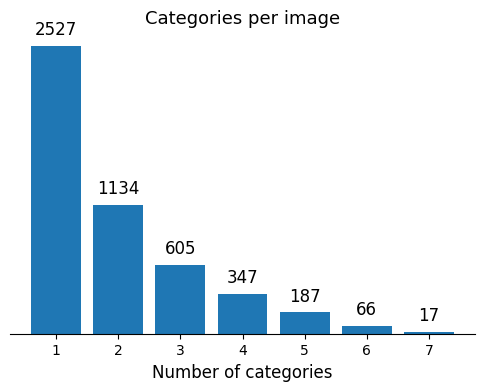

In [158]:
fig, ax = plt.subplots(1, 1, dpi=100)
ax.bar(x=[_ for _ in range(1, 8)], height=category_per_image_dict.values())
for key in category_per_image_dict:
    ax.text(key, category_per_image_dict[key]+100, category_per_image_dict[key], ha='center', fontdict={'size': 12})
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Categories per image', fontdict={'size': 13})
ax.set_xlabel('Number of categories', fontdict={'size': 12})

(100.0, 1500000.0)

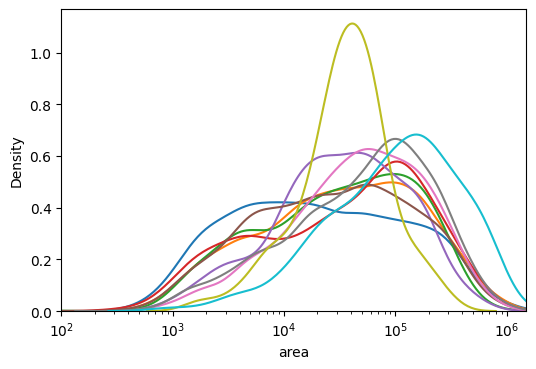

In [13]:
fig, ax = plt.subplots(1, 1, dpi=100)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 0, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 1, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 2, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 3, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 4, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 5, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 6, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 7, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 8, 'area'], ax=ax, log_scale=True)
sns.kdeplot(annotations_df.loc[annotations_df['category_id'] == 9, 'area'], ax=ax, log_scale=True)
ax.set_xlim(1e2, 1.5e6)

# Make JSON format